In this notebook I will implement the onion decomposition and try it on a climate network!

In [12]:
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
import cmplxNetworksUtilities as cnutils
import itertools
import graph_tool.all as gt

I could implement the OD using graph-tool, but I think it will be easier (and faster) if I just use numpy and work from the adjacency matrix.

In [232]:
def onion_decomp(A):
    '''
    Finds the onion decomposition of an undirected graph

    Inputs
    --------
    A: (N,N) ndarray 
        The adjacency matrix of the graph.

    Returns
    --------
    cores: (N,) ndarray
        Core number for each vertex as a 1D ndarray.
    layers: (N,) ndarray
        Layer number for each vertex as a 1D ndarray.

    # optional, maybe add later 
    num_cores: int
        Number of cores in the onion decomposition.
    num_layers: int
        Number of layers in the onion decomposition.
    '''
    # make sure A is square
    N = np.sqrt(np.size(A))
    assert(N-np.floor(N) == 0), 'Adjacency matrix must be square!'
    N = int(N)

    # produce diction of vertex:degree pairs
    # (technically the out-degree; axis=0 is the in-degree)
    degrees = np.sum(A, axis=1)
    verticies = dict(enumerate(degrees))
    # list of cores and layers to be filled in
    cores, layers = np.zeros(N), np.zeros(N)

    # first, remove all nodes of degree zero (they are the zeroth layer) to avoid problems with empty lists
    isolated_nodes = [v for v, d in verticies.items() if d == 0]
    for v in isolated_nodes:
        verticies.pop(v)

    curr_core, curr_layer = 1, 1
    while True:
        this_layer = [v for v, d in verticies.items() if d <= curr_layer]
        for v in this_layer:
            # update core/layer of each vertex
            cores[v], layers[v] = curr_core, curr_layer
            # decrease degree of each neighbour of vertex by 1
            neighbours, = np.nonzero(A[v])
            for neighbour in neighbours:
                if neighbour in verticies.keys():
                    verticies[neighbour] -= 1
            # remove current verticies from graph
            verticies.pop(v)

        # update current layer/core if verticies is non-empty
        if len(verticies) == 0:
            break
        curr_layer += 1
        min_deg = min(verticies.values())
        if min_deg >= (curr_core+1):
            curr_core = min_deg
    return cores, layers

In [275]:
def onion_spectrum(layers):
    '''
    Takes in the layers of the onion decomposition and produces the spectrum.

    Inputs
    -------
    layers: 1D ndarray of length N
        An array of layer numbers for each of the N verticies.

    Returns
    --------
    frac_in_layer: 1D ndarray
        For an onion decomposition resulting in m layers, a list of length m whose m-th entry is the fraction of all nodes in layer m. 
    '''
    N = len(layers)
    total_layers = np.arange(np.max(layers)+1)
    frac_in_layer = [(np.sum(layers == layer)/N) for layer in total_layers]

    return total_layers, frac_in_layer

# Real data!

In [278]:
# reimport adjacency matricies
recreation = Dataset('../Output/tsonisCorrelationsRecreation.nc')
elnino_adj = recreation.groups['elNino'].variables['adjacency'][:]
lanina_adj = recreation.groups['laNina'].variables['adjacency'][:]
# make the matricies easier to access later
adj_matricies = [elnino_adj, lanina_adj]

In [294]:
names = ['El Nino', 'La Nina']

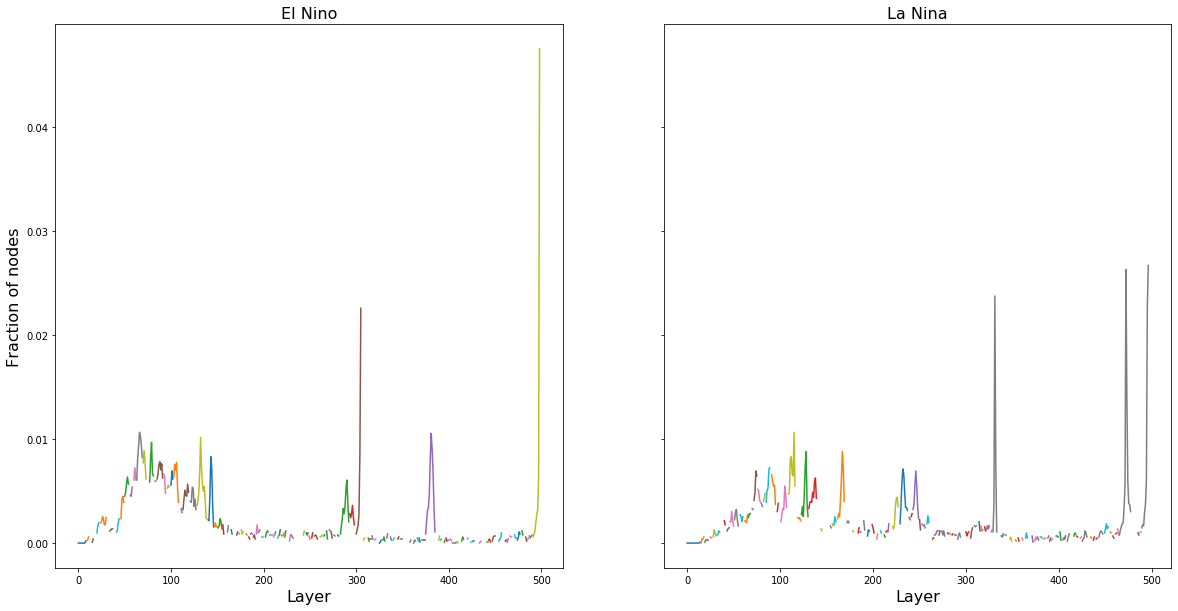

In [299]:
fig, ax = plt.subplots(ncols=2, sharey=True)
fig.set_figheight(10)
fig.set_figwidth(20)
fig.set_facecolor('white')

for idx in [0, 1]:
    cores, layers = onion_decomp(adj_matricies[idx])
    total_layers, frac_in_layer = onion_spectrum(layers)

    previous_max = 0
    for core in np.unique(cores):
        max_layer_in_core = max(layers[cores == core]).astype('int')
        ax[idx].plot(total_layers[previous_max:max_layer_in_core+1],
                     frac_in_layer[previous_max:max_layer_in_core+1], label=core)
        previous_max = max_layer_in_core+1
    # ax[idx].legend(title='Cores')
    ax[idx].set_title(names[idx], fontsize=16)
    ax[idx].set_xlabel('Layer', fontsize=16)
ax[0].set_ylabel('Fraction of nodes', fontsize=16)
fig.savefig('../Output/TsonisRecreationOnionDecomp.jpg')